![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Augmentation & Regularization </center>
### <center> Mixup </center>

Colab users should use GPU runtime:  
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/07_PyTorch2/MainPyTorchTensorBoard.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/Exercises/Ex4/DeepLearningFramework_Solution ./DeepLearningFramework_Solution
    !pip install torchinfo

In [4]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
import torchvision
import torchvision.transforms as transforms
import torchinfo

from torch.optim.lr_scheduler import OneCycleLR

torch.backends.cudnn.benchmark = True

### Load Fashion-MNIST data:

In [5]:
import torchvision
import torchvision.transforms as transforms

oTransform = transforms.Compose([
    transforms.ToTensor (),
    transforms.Normalize(0.5, 0.5)
])

DATA_PATH = '../../../data/'
oTrainSet = torchvision.datasets.FashionMNIST(DATA_PATH, download=True, train=True,  transform=oTransform)
oTestSet  = torchvision.datasets.FashionMNIST(DATA_PATH, download=True, train=False, transform=oTransform)
lClasses  = oTrainSet.classes

#### Plot some examples:

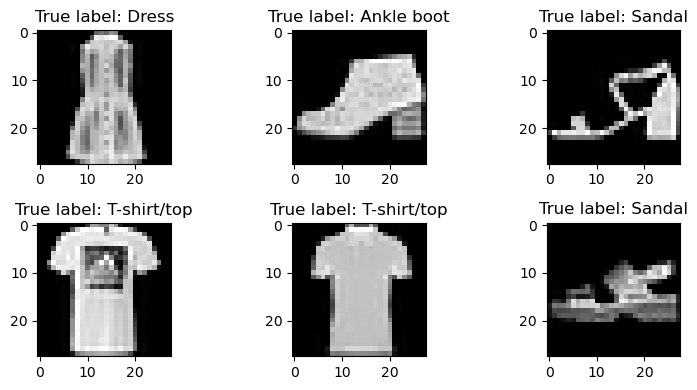

In [6]:
def Unnormalize(mX):
    return 0.5 * mX + 0.5

N, H, W = oTrainSet.data.shape
fig, _  = plt.subplots(2, 3, figsize=(8, 4))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    mX    = Unnormalize(mX[0])
    mX    = torch.clamp(mX, 0, 1)
    ax.imshow   (mX, cmap='gray')
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show        ()

#### Data-loader:

In [7]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, batch_size=1*batchSize, shuffle=True,  num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  batch_size=2*batchSize, shuffle=False, num_workers=2, persistent_workers=True)

mX, vY    = next(iter(oTrainDL))
mX.shape

torch.Size([128, 1, 28, 28])

#### Define a model:

In [8]:
class ResBlock(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.oBlock = nn.Sequential(
            nn.Identity(),
            nn.Conv2d(C, C,   3, padding=1, stride=1), nn.BatchNorm2d(1*C), nn.LeakyReLU(0.2),
            nn.Conv2d(C, 2*C, 3, padding=1, stride=2), nn.BatchNorm2d(2*C), nn.LeakyReLU(0.2),
        )
        
    def forward(self, mX):
        mOut  = self.oBlock(mX)
        mX    = F.interpolate(mX, scale_factor=[1/2, 1/2])
        mOut += mX.repeat(1,2,1,1)
    
        return mOut

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.oNN = nn.Sequential(
            nn.Identity(),
            nn.Conv2d(1,   16, kernel_size=3, padding=3), nn.LeakyReLU(), 
            ResBlock (16),
            ResBlock (32),
            ResBlock (64),
            ResBlock (128),
            nn.Conv2d(256, 10, kernel_size=2),                                            
            nn.Flatten()
        )
        
    def forward(self, mX):
        vScore = self.oNN(mX)
    
        return vScore
#=============================================================#
#=============================================================#
print(torchinfo.summary(Model(), mX.shape))

vScore = Model()(mX)
vScore.shape

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Identity: 2-1                     [128, 1, 28, 28]          --
│    └─Conv2d: 2-2                       [128, 16, 32, 32]         160
│    └─LeakyReLU: 2-3                    [128, 16, 32, 32]         --
│    └─ResBlock: 2-4                     [128, 32, 16, 16]         --
│    │    └─Sequential: 3-1              [128, 32, 16, 16]         7,056
│    └─ResBlock: 2-5                     [128, 64, 8, 8]           --
│    │    └─Sequential: 3-2              [128, 64, 8, 8]           27,936
│    └─ResBlock: 2-6                     [128, 128, 4, 4]          --
│    │    └─Sequential: 3-3              [128, 128, 4, 4]          111,168
│    └─ResBlock: 2-7                     [128, 256, 2, 2]          --
│    │    └─Sequential: 3-4              [128, 256, 2, 2]          443,5

C:\Users\oryai\anaconda3\lib\site-packages\torch\nn\functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


torch.Size([128, 10])

In [10]:
from DeepLearningFramework_Solution.Auxiliary import RandBox

def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #====================================================================================================#
            α    = 1
            λ    = np.random.beta(α, α)
            vIdx = torch.randperm(mX.shape[0], device=DEVICE)
            
            mX = λ * mX + (1 - λ) * mX[vIdx]
            # vY = λ * vY + (1 - λ) * vY[vIdx]
            
            mZ   = oModel(mX)
            loss = λ * Loss(mZ, vY) + (1 - λ) * Loss(mZ, vY[vIdx])
            #====================================================================================================#
            
            #-- Backward:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward   () #-- backward
            oOptim.step     () #-- update parameters
            vLR[ii] = oScheduler.get_last_lr()[0]
            oScheduler.step() #-- update learning rate
            
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)
                loss = Loss  (mZ, vY)

        Nb           = vY.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        if bTrain == True:
            epochMetric += Nb * (λ * Metric(mZ, vY) + (1 - λ) * Metric(mZ, vY[vIdx]))
        else:
            epochMetric += Nb * Metric(mZ, vY)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [11]:
import time

from DeepLearningFramework_Solution.Metric import Accuracy

def TrainClassficationModel(oModel, oTrainData, oValData, Loss, nEpochs, oOptim, oScheduler=None):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    vLR        = np.full(0,       np.nan)
    bestAcc    = 0

    for epoch in range(nEpochs):
        startTime                 = time.time()
        trainLoss, trainAcc, vLRi = Epoch(oModel, oTrainData, Loss, Accuracy, oOptim, oScheduler, bTrain=True ) #-- train
        valLoss,   valAcc,   _    = Epoch(oModel, oValData,   Loss, Accuracy,                     bTrain=False) #-- validate
        epochTime                 = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',   end='')
        print(' | Train loss: '     f'{trainLoss:.5f}' ,   end='')
        print(' | Val loss: '       f'{valLoss  :.5f}' ,   end='')
        print(' | Train Accuracy: ' f'{trainAcc :2.4f}',   end='')
        print(' | Val Accuracy: '   f'{valAcc   :2.4f}',   end='')
        print(' | epoch time: '     f'{epochTime:6.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc
        vLR               = np.concatenate([vLR, vLRi])

        #-- Save best model (early stopping):
        if bestAcc < valAcc:
            bestAcc = valAcc
            try:
                torch.save(oModel.state_dict(), 'BestModel.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load('BestModel.pt'))

    return vTrainLoss, vTrainAcc, vValLoss, vValAcc, vLR

#### Device:

In [12]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

In [13]:
from torch.optim import lr_scheduler

nEpochs = 50
nIter   = nEpochs * len(oTrainDL)
Loss    = nn.CrossEntropyLoss()

oModel        = Model                  ().to(DEVICE)
oOptim        = optim.Adam             (oModel.parameters(), lr=0, betas=(0.9, 0.99))
oScheduler    = lr_scheduler.OneCycleLR(oOptim, max_lr=5e-3, total_steps=nIter)
lHistory      = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

C:\Users\oryai\anaconda3\lib\site-packages\torch\nn\functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


Epoch 000: | Train loss: 1.05832 | Val loss: 0.42790 | Train Accuracy: 0.6307 | Val Accuracy: 0.8562 | epoch time:  5.616 | <-- Checkpoint!
Epoch 001: | Train loss: 0.89607 | Val loss: 0.39676 | Train Accuracy: 0.6806 | Val Accuracy: 0.8670 | epoch time:  3.815 | <-- Checkpoint!
Epoch 002: | Train loss: 0.87165 | Val loss: 0.36445 | Train Accuracy: 0.6759 | Val Accuracy: 0.8849 | epoch time:  3.861 | <-- Checkpoint!
Epoch 003: | Train loss: 0.85327 | Val loss: 0.38385 | Train Accuracy: 0.6788 | Val Accuracy: 0.8765 | epoch time:  3.829 |
Epoch 004: | Train loss: 0.83719 | Val loss: 0.34028 | Train Accuracy: 0.6798 | Val Accuracy: 0.8912 | epoch time:  3.833 | <-- Checkpoint!
Epoch 005: | Train loss: 0.82548 | Val loss: 0.33356 | Train Accuracy: 0.6779 | Val Accuracy: 0.8944 | epoch time:  3.932 | <-- Checkpoint!
Epoch 006: | Train loss: 0.80860 | Val loss: 0.29711 | Train Accuracy: 0.6881 | Val Accuracy: 0.9027 | epoch time:  3.868 | <-- Checkpoint!
Epoch 007: | Train loss: 0.81043 | V

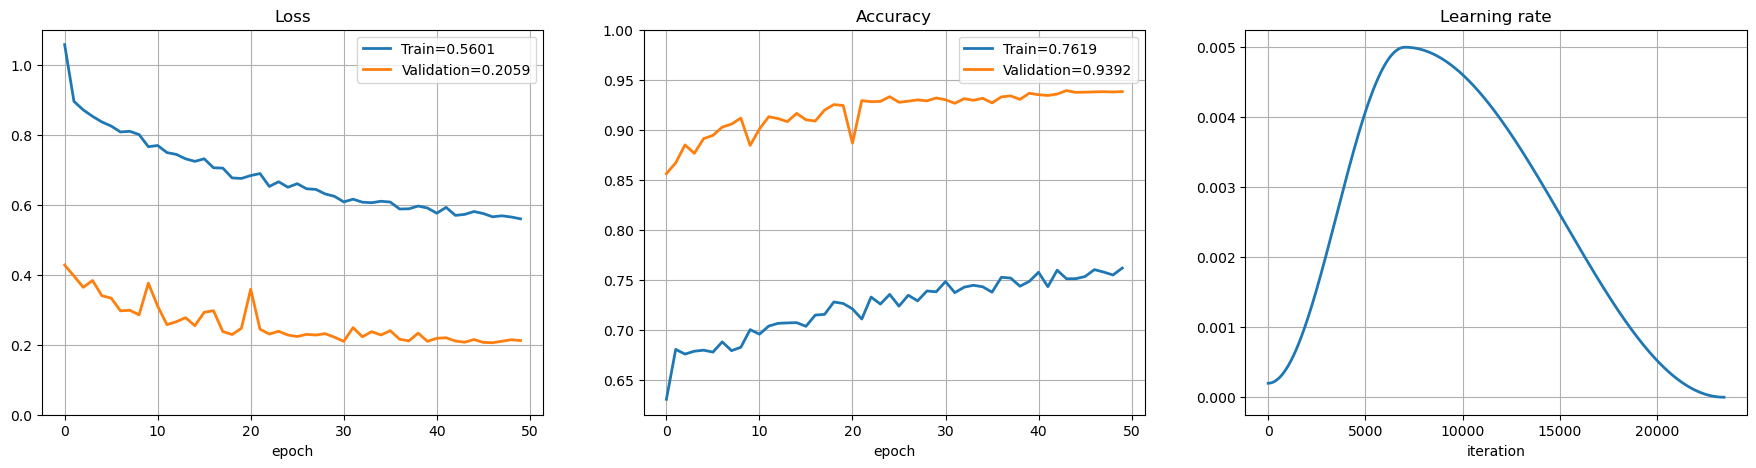

In [14]:
from DeepLearningFramework_Solution.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()